# Activity Landscapes
This notebook was created by [Christian Feldmann](https://github.com/c-feldmann/). In case of questions you can contact me via christian.w.feldmann@gmail.com.
## To Optimize:
 - Choice of Kernel for Gaussian Process may be improved
 - Finding a better transformation of standard-deviation to uncertainty in plot

In [1]:
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw, Descriptors, AllChem, DataStructs
from scipy import sparse
import seaborn as sns
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.decomposition import KernelPCA
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
import sklearn.model_selection as sklms

from sklearn.preprocessing import MinMaxScaler
import sys
from tqdm.notebook import tqdm

## Loading and Visualizing Data

In [2]:
chembl_data_df = pd.read_csv('./CHEMBL3130_potencies.tsv', sep = '\t')

In [3]:
chembl_data_df.groupby("standard_type").count()["nonstereo_aromatic_smiles"]

standard_type
IC50    1378
Kd        31
Ki       135
Name: nonstereo_aromatic_smiles, dtype: int64

In [4]:
chembl_data_df = chembl_data_df.query("standard_type == 'IC50'")
chembl_data_df["pIC50"] = 9-np.log10(chembl_data_df["standard_value"].values)
print(chembl_data_df.shape)

(1378, 11)


<AxesSubplot:xlabel='pIC50', ylabel='Density'>

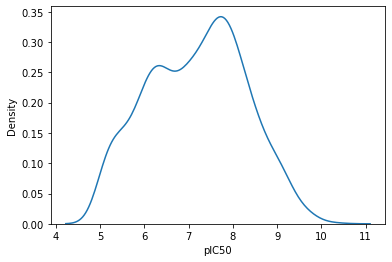

In [5]:
sns.kdeplot(chembl_data_df.pIC50)

## Embedding Molecules in 2D coordinates
### Generating Molecular Fingerprints and Similarities

In [6]:
chembl_data_df["mol_obj"] = chembl_data_df.nonstereo_aromatic_smiles.apply(Chem.MolFromSmiles)
def fp(mol_obj):
    return AllChem.GetMorganFingerprintAsBitVect(mol_obj, 2)
chembl_data_df['FP'] = chembl_data_df.mol_obj.apply(fp)

In [7]:
def similarity_from_sparse(matrix_a: sparse.csr_matrix, matrix_b: sparse.csr_matrix):
    intersection = matrix_a.dot(matrix_b.transpose()).toarray()
    norm_1 = np.array(matrix_a.multiply(matrix_a).sum(axis=1))
    norm_2 = np.array(matrix_b.multiply(matrix_b).sum(axis=1))
    union = norm_1 + norm_2.T - intersection
    return intersection / union

In [8]:
sparse_fp_matrix = sparse.csc_matrix(np.vstack(chembl_data_df.FP.values))
smiliarity_matrix = similarity_from_sparse(sparse_fp_matrix, sparse_fp_matrix)

### Applying Embedding Methods

In [9]:
method = "MDS"

In [10]:
if method == "MDS":
    embedding = MDS(n_components=2, dissimilarity='precomputed')
    # expects dissimilarity matrix
    X_transformed = embedding.fit_transform(1-smiliarity_matrix)
elif method == "TSNE":
    embedding = TSNE(n_components=2, metric='precomputed')
    # expects distance matrix
    X_transformed = embedding.fit_transform(1-smiliarity_matrix)
elif method == "Kernel PCA":
    embedding = KernelPCA(n_components=2, kernel='precomputed')
    X_transformed = embedding.fit_transform(smiliarity_matrix)
else:
    raise NotImplementedError

In [11]:
embedding_df = pd.DataFrame(X_transformed, columns=["x", "y"])
embedding_df["acitivity"] = chembl_data_df.pIC50.values

### Quick Visualization of the Embedding

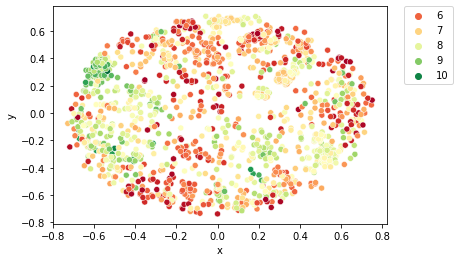

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=embedding_df, x="x", y="y", hue="acitivity", palette="RdYlGn")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Landscape Creation
### Creating a Gaussian Process for Activity Predictions

In [13]:
param_grid = {"alpha": 10.**np.arange(-10, 10, 2),
              "kernel": np.array([RBF(10.**k, (1e-1, 1e5)) for k in np.arange(-5,5,1)])}

In [14]:
model = sklms.GridSearchCV(GaussianProcessRegressor(normalize_y=True),
                       param_grid=param_grid,
                       n_jobs=-1,
                       cv=5
                       )

model.fit(X_transformed, embedding_df["acitivity"])
gaussian_regressor = model.best_estimator_

In [15]:
print("Best parameter for model")
model.best_params_

Best parameter for model


{'alpha': 1.0, 'kernel': RBF(length_scale=10)}

### Creating a Grid withing the Embedded Space

In [16]:
resolution = 1000

# Calculate min and max x&y values and increase by 10 %
x_lim = np.array((min(X_transformed[:,0]), max(X_transformed[:,0]))) * 1.1
y_lim = np.array((min(X_transformed[:,1]), max(X_transformed[:,1]))) * 1.1

x_ax_v = np.linspace(x_lim[0], x_lim[1], resolution)
y_ax_v = np.linspace(y_lim[0], y_lim[1], resolution)[::-1]
gridx, gridy = np.meshgrid(x_ax_v, y_ax_v)

### Estimating Activity and Standard-Deviation for Grid-Points
Transforming the grid-space to an array of 2D coordinates understood by the Gaussian Process Regressor.

In [17]:
transfromed_input = np.array([gridx.ravel(), gridy.ravel()]).T
activity_predict, activity_std = gaussian_regressor.predict(transfromed_input, return_std=True)

### Transforming Activities to Colors

In [18]:
def gen_colormapping(v_min, v_max, color="RdYlGn"):
    cmap = mpl.cm.get_cmap(color)
    norm = mpl.colors.Normalize(vmin=v_min, vmax=v_max)
    return lambda x: cmap(norm(x))

In [19]:
red_green_mapping = gen_colormapping(activity_predict.min(), activity_predict.max())
scaled_std = MinMaxScaler().fit_transform(activity_std.reshape(-1, 1)).ravel()

In [20]:
activity_predict_reshape = activity_predict.reshape(gridx.shape)
activity_color = red_green_mapping(activity_predict_reshape)

# Adding alpha channel as 1 - scaled STD.
#High STDs will lead to low alpha-values. Alpha values indicate color intensity
activity_color[..., -1] = 1 - scaled_std.reshape(gridx.shape)

### Visualizing the Landscape in 2D

<AxesSubplot:xlabel='x', ylabel='y'>

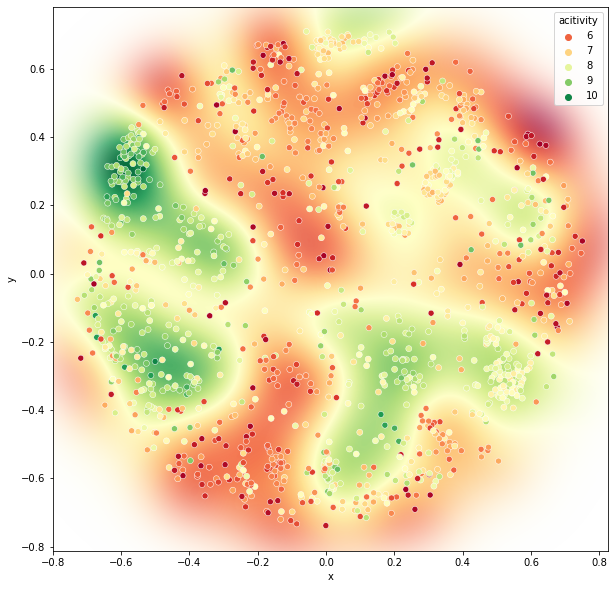

In [21]:
fig, ax = plt.subplots(figsize=(10,10))
out = ax.imshow(activity_color, extent=(*x_lim, *y_lim))
sns.scatterplot(data=embedding_df, x="x", y="y", hue="acitivity", ax=ax, palette="RdYlGn")

## Visualizing the Landscape in 3D
### Landscape without uncertainty.

<IPython.core.display.Javascript object>


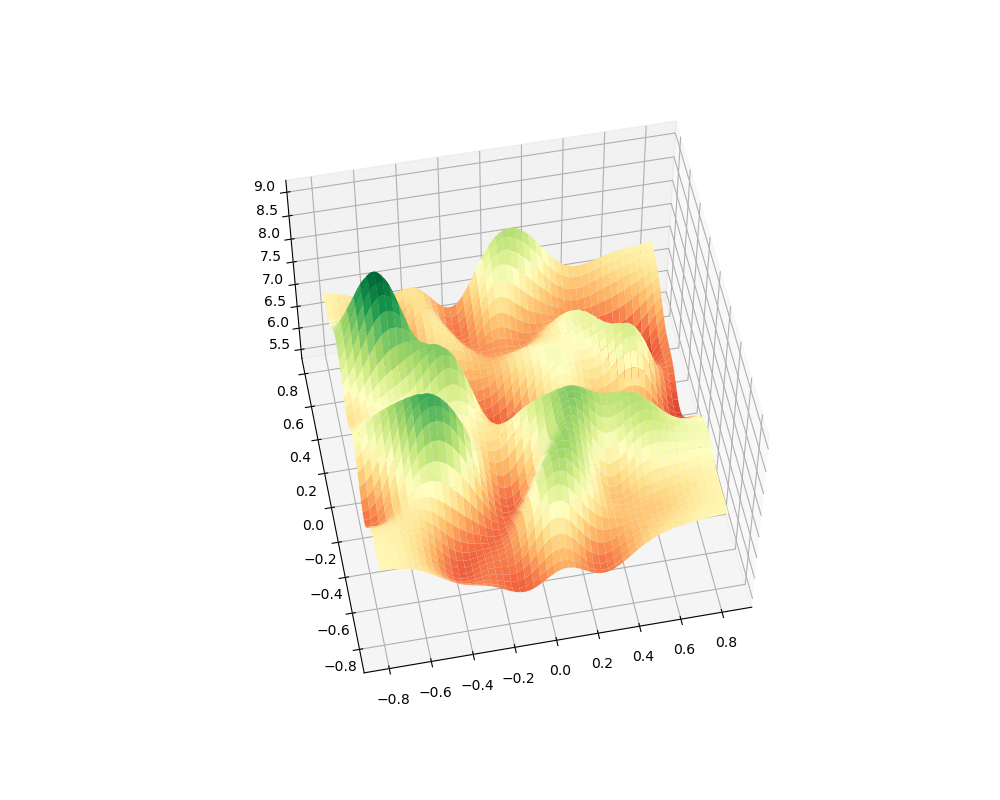

In [22]:
%matplotlib notebook
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
ax.plot_surface(gridx, gridy, activity_predict_reshape, cmap="RdYlGn", linewidth=0, antialiased=True, alpha=1)
#ax.scatter(embedding_df.x, embedding_df.y, embedding_df.acitivity, marker="o", color=red_green_mapping(embedding_df.acitivity))

### Landscape with uncertainty as transparency.

<IPython.core.display.Javascript object>


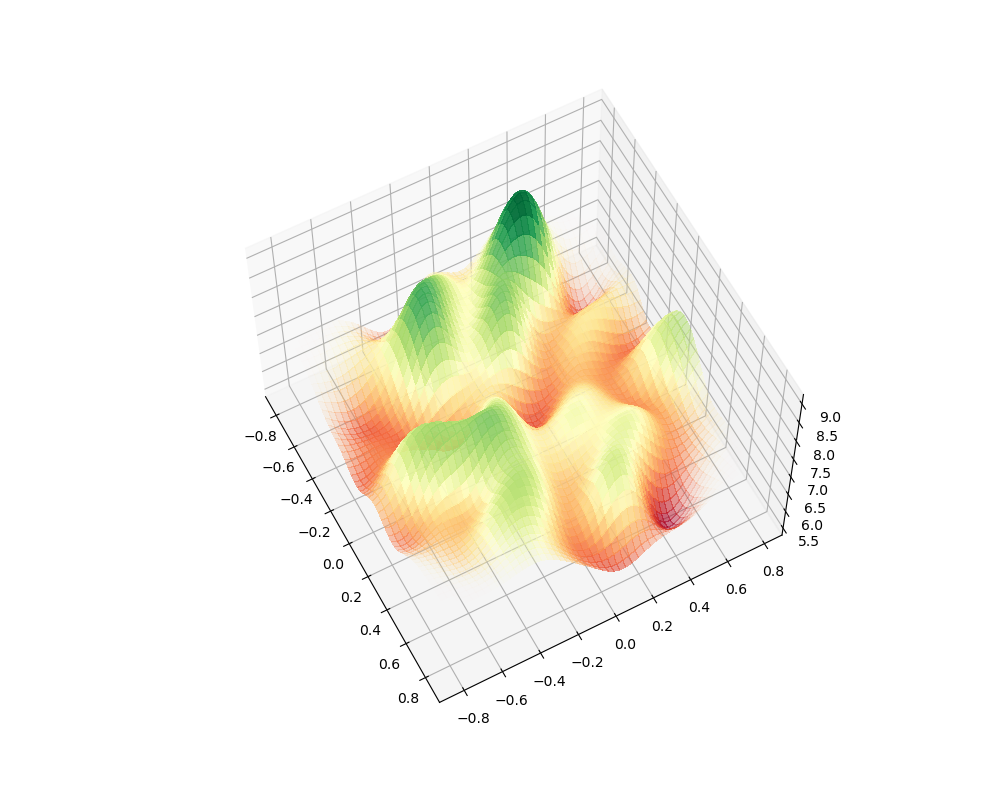

In [23]:
activity_color2 = red_green_mapping(activity_predict_reshape)
activity_color2[:,:,3] *= 1- scaled_std.reshape(gridx.shape)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
ax.plot_surface(gridx, gridy, activity_predict_reshape, facecolors=activity_color2, linewidth=0, antialiased=False, shade=False)

### Landscape with uncertainty as white.

<IPython.core.display.Javascript object>


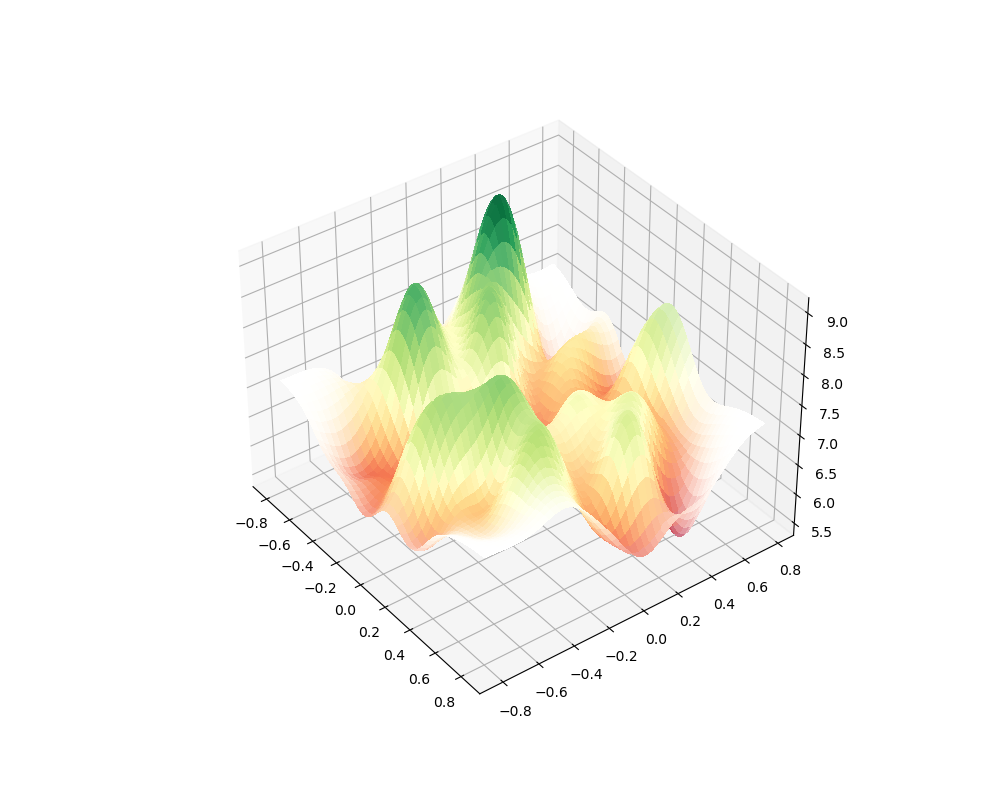

In [24]:
activity_color3 = red_green_mapping(activity_predict_reshape)
reshaped_scaled_std = scaled_std.reshape(gridx.shape)
for i in range(3):
    activity_color3[:,:,i] = 1 * reshaped_scaled_std + (1-reshaped_scaled_std) * activity_color3[:,:,i]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
ax.plot_surface(gridx, gridy, activity_predict_reshape, facecolors=activity_color3, linewidth=0, antialiased=False, shade=False)

### Landscape with uncertainty as gray.

<IPython.core.display.Javascript object>


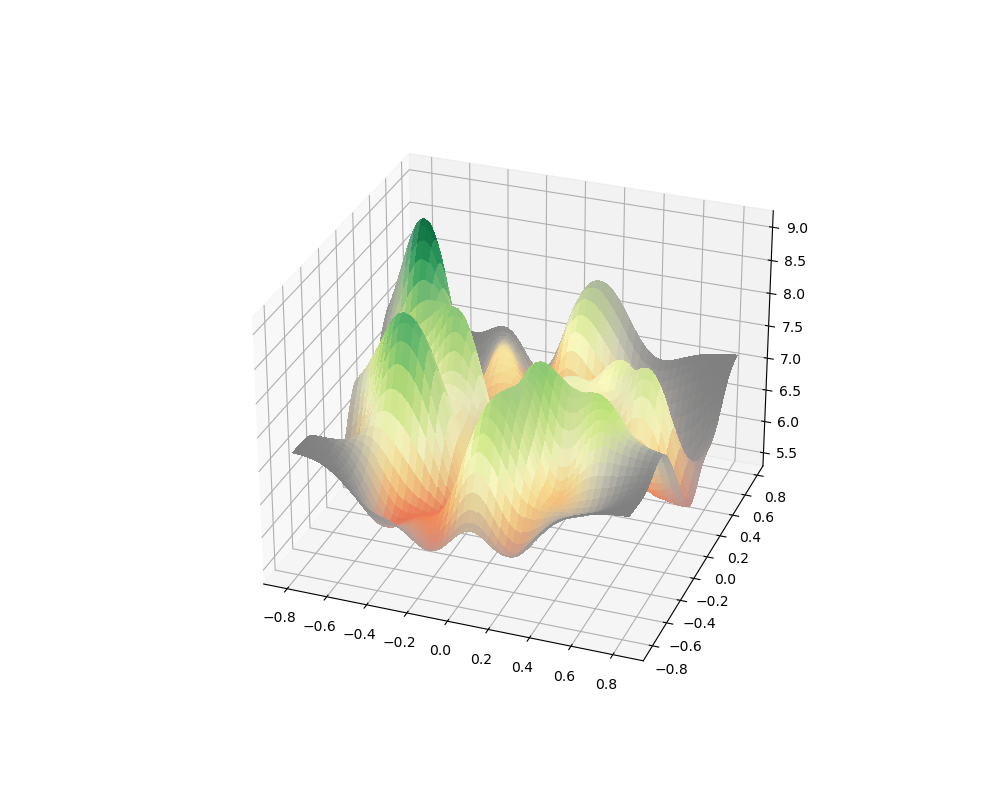

In [25]:
activity_color4 = red_green_mapping(activity_predict_reshape)
reshaped_scaled_std = scaled_std.reshape(gridx.shape)
for i in range(3):
    activity_color4[:,:,i] = 0.5 * reshaped_scaled_std + (1-reshaped_scaled_std) * activity_color3[:,:,i]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,8))
ax.plot_surface(gridx, gridy, activity_predict_reshape, facecolors=activity_color4, linewidth=0, antialiased=False, shade=False)